# Gravitational coupling between millimetre-sized masses

_Andrea Mari, NQSTI, University of Camerino, Italy._

In this notebook we simulate and numerically reproduce the results of the remarkable experiment published in [T Westphal, H Hepach, J Pfaff, M Aspelmeyer, _Nature_, 591, 2021](https://doi.org/10.1038/s41586-021-03250-7)  (free version  [arXiv:2009.09546](https://arxiv.org/abs/2009.09546)) in which the gravitational force generated by a small gold sphere of 1 millimeter radius and mass $m_{\rm s}$ = 91.5 mg was detected by measuring the position of a nearby gold sphere (of mass $m_{\rm t}$=92.1 mg) acting as a test mass.

The scheme of the experimental setup is shown in the following image (extracted from [arXiv:2009.09546](https://arxiv.org/abs/2009.09546)):

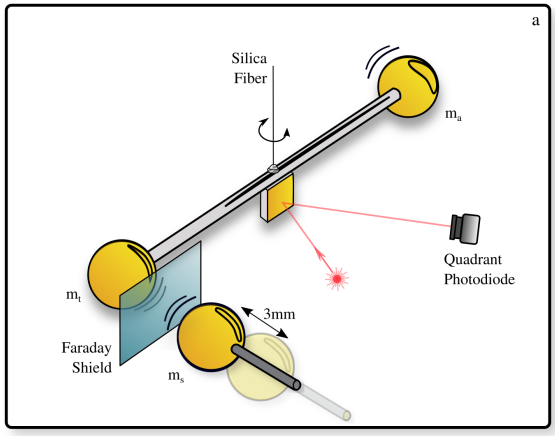

In the experiment, the position of the source mass was mechanically modulated at a frequency $f_{\rm mod}$ = 12.7 mHz. In particular, distance between the source mass and the test mass was changed in time according to the sinusoidal function $d(t)=d_0 + d_{\rm mod} \sin(2 \pi f_{\rm mod} t)$, where $d_0$ = 4.2 mm is the average distance and $d_{\rm mod}$ = 1.6 mm is the maximum modulation shift.
The test mass was attached to a torsion pendulum with frequency $f$ = 3.59 mHz $\neq$ $f_{\rm mod}$, effective mass $m \simeq m_{\rm t} + m_{\rm s}$ = 183.8 mg, and quality factor $Q$ = 4.9, in a Cavendish-like configuration.

The gravitational force between the two gold spheres is given by the Newton formula:

$$F(t)=G \frac{m_{\rm s} m_{\rm t}}{d(t)^2}=  G \frac{m_{\rm s} m_{\rm t}}{[d_0 + d_{\rm mod} \sin(2 \pi f_{mod} t)]^2}.$$

The aim of the original experiment and of the present notebook is to detect the time-dependent gravitational force signal in the frequency spectrum of the test mass position. Since $F(t)$ is modulated, we expect the main signal at frequency $f_{\rm mod}$ and, potentially, also at higher harmonics (integer multiples of $f_{\rm mod}).$


## Theoretical model of a damped harmonic oscillator driven by an external force

The equations of motion (aka Langevin equations) for a noisy harmonic oscillator of mass $m$, angular frequency $\omega_0$, friction constant $\eta$ and driven by an external gravitational force $F(t)$ are:

\begin{align}
\dot{q} &= \frac{1}{m} p ,\\
\dot{p} & = m \omega_{0}^2 q  - \frac{\eta}{m} p + \xi(t) + F(t) + \delta F(t),  \\
\end{align}

where $q$ is the position of the 1D harmonic oscillator, $p$ is the linear momentum, $\xi(t)$ is a zero-mean stochastic variable that represents the unavoidable mechanical thermal noise, and $\delta F(t)$ is a zero-mean stochastic variable that represents the noise in the gravitational force.

The total force acting on the oscillator is:
$$
F_{\rm tot}(t) = F(t) + \xi(t) + \delta F(t),
$$

the signal that we aim to detect is $F(t)$, while both terms $\xi(t)$ and $\delta F(t)$ act as additional  noise disturbing the signal. Assuming the noise is white and Gaussian, we have the following  correlation functions:


$$
\langle \delta F(t) \delta F(t') \rangle = D_F \delta(t - t'),
$$


$$
\langle \delta \xi(t) \delta \xi(t') \rangle = D_\xi \delta(t - t'),
$$

where $\langle \cdot \rangle$ is the average over many stochastic realizations and the diffusion parameters $D_F$ and $D_\xi$ represent the strength of the force noise and of the environmental noise respectively. 

While $D_F$ is arbitrary since it depends on the details of the gravitational source, $D_\xi$ is given by the theory of Brownian motion and, in particular, by the fluctuation-dissipation theorem:

$$
 D_\xi =2 \eta {k_{\rm B} T} ,
$$
where $T$ is the temperature and $k_{\rm B}$ is the Boltzmann constant. See, e.g., Caldeira, Leggett,
Physica A, Vol. 121, Issue 3, (1983).

## System settings

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
# Conversion factors
meter_to_nano = 10 ** 9
newton_to_femto = 10 ** 15
hertz_to_milli = 10 ** 3
milli_to_hertz = 10 ** -3
milli_to_meter = 10 ** -3
milligram_to_kg = 10 ** -6
hours_to_seconds = 3600

# Mechanical oscillator
test_mass = 92.1 * milligram_to_kg
mass = 183.8  * milligram_to_kg  # Effective mass in torsion pendulum
frequency = 3.59 *  milli_to_hertz
omega_zero = frequency * 2 * np.pi
quality_factor = 4.9
gamma = omega_zero / quality_factor   # Energy decay rate
eta = mass * gamma    # Friction constant (F=-eta*velocity)

# Sampling setting
num_hours = 13.8 # Nature paper 13h
num_seconds = num_hours * hours_to_seconds
num_samples = 3 * 10**4
t_step = num_seconds / num_samples
t_values = np.linspace(0, num_seconds, num_samples)

Before simulating the dynamics of the test mass, we generate in advance the time series of all the terms of the total driving force: thermal noise, force signal and force noise.

## Total force acting on the oscillator


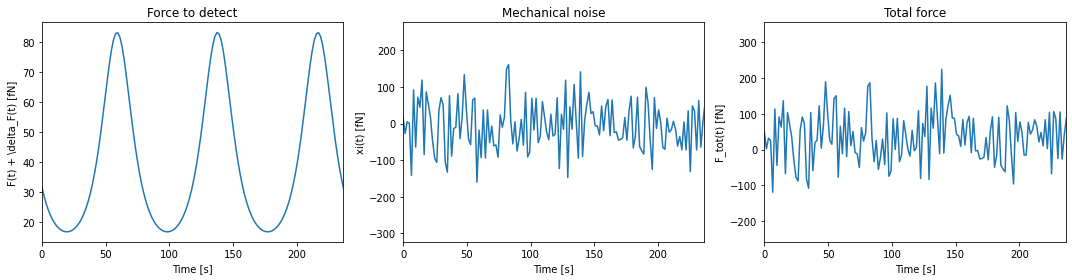

In [3]:
# Mechanical noise
k_B = 1.38 * (10 ** -23)  # Boltzmann constant
T = 300
D_xi = 2 * eta * k_B * T  # Diffuction parameter
mechanical_noise_per_step = np.sqrt(D_xi / t_step)
mechanical_noise_values = mechanical_noise_per_step * np.random.normal(size=num_samples)

# Force signal to detect
G =  1.0 * 6.6743 * 10**(-11)
source_mass = 91.5 * milligram_to_kg
source_distance = 4.2 * milli_to_meter
source_distance_modulation = 1.6 * milli_to_meter
source_frequency = 12.7 * milli_to_hertz
source_omega = source_frequency * 2 * np.pi
total_distance_values = source_distance + source_distance_modulation * np.sin(source_omega * t_values)
force_signal_values = (G * test_mass * source_mass) / (total_distance_values ** 2)

# Noise in gravitational source
D_F = 0 * 0.001 * D_xi  # E.g. 0.1% of mechanical noise 
force_noise_per_step = np.sqrt(D_F / t_step)
force_noise_values = force_noise_per_step * np.random.normal(size=num_samples)


# Total force values
force_values = force_signal_values + force_noise_values + mechanical_noise_values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.plot(t_values, newton_to_femto * (force_signal_values + force_noise_values))
ax1.set_title("Force to detect")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("F(t) + \delta_F(t) [fN]")
ax1.set_xlim(0, 3 / source_frequency)
ax2.plot(t_values, newton_to_femto * mechanical_noise_values)
ax2.set_title("Mechanical noise")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("xi(t) [fN]")
ax2.set_xlim(0, 3 / source_frequency)
ax3.plot(t_values, newton_to_femto * force_values)
ax3.set_title("Total force")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("F_tot(t) [fN]")
ax3.set_xlim(0, 3 / source_frequency)
plt.tight_layout()

From the above plots, it seems that the periodic gravitational force signal is completely masked by thermal noise. However, the signal is still quite visible in the frequency domain.

### Force spectrum

We first analyze the spectrum of the total force acting on the oscillator. 
We use `scipy.signal.welch` to compute the force _power spectrum_. The square root of the force power spectrum, gives us the _force spectrum_.

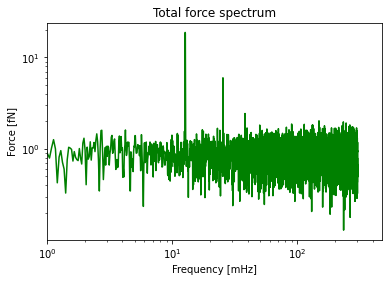

In [4]:
f, force_power_spectrum = signal.welch(force_values, fs=1.0/t_step, nperseg=num_samples // 2, scaling="spectrum")
force_spectrum =  np.sqrt(force_power_spectrum)

plt.loglog(f * hertz_to_milli, newton_to_femto * force_spectrum, color="green")
plt.xlim(1, None) # Ignore very low frequencies
plt.title('Total force spectrum')
plt.xlabel('Frequency [mHz]')
plt.ylabel('Force [fN]')
plt.show()

In the force spectrum we see the main peak of the gravitational force signal at frequency $f_{\rm mod}$ = 12.7 and its first harmonic at 2 $f_{\rm mod}$ = 25.4 mHz.
The above spectrum is not directly measurable, but it can be deduced from the position spectrum of the test mass, as we are going to show in the next sections.

## Simulation of system dynamics

In the next code cell, we solve the differential equation by a simple application of the [Euler method](https://en.wikipedia.org/wiki/Euler_method).

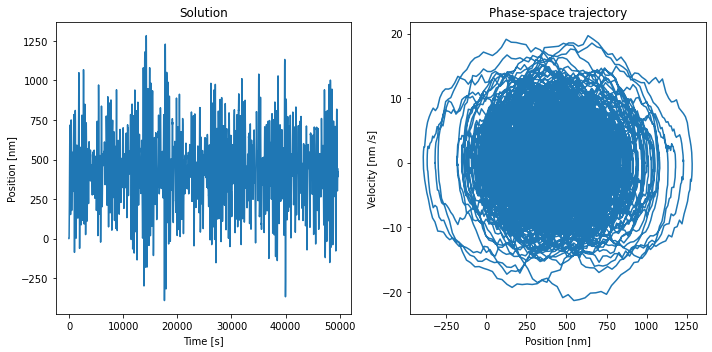

In [5]:
def r_dot(r, force):
    """Right-hand side of the differential equation for the array r(t)=[q(t),p(t)]."""
    q, p = r
    q_dot = p / mass
    p_dot = -(mass * (omega_zero ** 2)) * q - (eta / mass) * p + force
    return np.array([q_dot, p_dot])

def euler_solution(r_dot, r_zero, force_values):
    r_sol = [r_zero]
    for force in force_values[:-1]:
        delta_r = r_dot(r_sol[-1], force) * t_step
        r_sol.append(r_sol[-1] + delta_r)
    return np.array(r_sol)

r_zero = [0.0, 0.0]
r_euler = euler_solution(r_dot, r_zero, force_values)
q_euler = r_euler[:, 0]
p_euler = r_euler[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(t_values, meter_to_nano * q_euler)
ax1.set_title("Solution")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Position [nm]")
ax2.plot(meter_to_nano * q_euler, meter_to_nano * p_euler / mass)
ax2.set_title("Phase-space trajectory")
ax2.set_xlabel("Position [nm]")
ax2.set_ylabel("Velocity [nm /s]")
plt.tight_layout()

## Spectrum of the test mass position

We now compute the _position spectrum_ by post-processing the numerical solution for $q(t)$.

We also plot the theoretical prediction for the position spectrum (evaluated without the gravitational force).
For a driven and damped harmonic oscillator of frequency $\omega_0$ and friction constant $\eta$ (energy decay rate $\gamma=\eta/m$), the power spectral density of the position is linked to the power spectral density of the driving force by the absolute modulus of mechanical [susceptibility](https://en.wikipedia.org/wiki/Linear_response_function) $\chi(\omega)=(\omega- \omega_0^2 -  i \gamma \omega)^{-1}/m$. Specifically, we have:

$$Sqq(\omega) = |\chi(\omega)|^2 S_{F_{\rm tot} F_{\rm tot}}(\omega)= \dfrac {1}{m^2} \dfrac{1 }{(\omega^2- \omega_0^2)^2 + \gamma^2 \omega^2} S_{F_{\rm tot} F_{\rm tot}}(\omega).$$

Without gravitational force, $S_{F_{\rm tot} F_{\rm tot}}(\omega)=S_{\xi \xi}(\omega)=D_\xi$, i.e., the oscillator is only driven by thermal noise. Therefore the theoretical model for the thermal contribution to the position spectrum is given by:

$$S_q^{(\rm thermal)}(\omega) = \sqrt{S_{qq}^{(\rm thermal)}(\omega)} = |\chi(\omega)| \sqrt{D_{\xi}}.$$

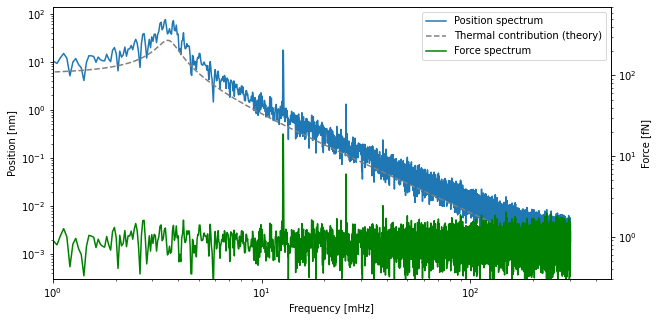

In [6]:
f, qq_spectrum = signal.welch(q_euler, fs=1/t_step, nperseg=num_samples // 2, scaling="spectrum")
q_spectrum =  np.sqrt(qq_spectrum)

# Theoretical estimate of position spectrum without force
omega_values = 2 * np.pi * f
susceptibility = (1 / mass) / (omega_values**2 - omega_zero**2 + 1.0j * gamma * omega_values)
theoretical_spectral_density_without_force = np.abs(susceptibility) * np.sqrt(D_xi)
frequency_bin = f[1] - f[0]
theoretical_spectrum_without_force = np.sqrt(frequency_bin) * theoretical_spectral_density_without_force

fig, (ax1) = plt.subplots(1, figsize=(10, 5))
ax1.loglog(hertz_to_milli * f, meter_to_nano * q_spectrum, label="Position spectrum")
ax1.loglog(
    hertz_to_milli * f,
    meter_to_nano * theoretical_spectrum_without_force,
    '--',
    color="gray",
    label="Thermal contribution (theory)"
)
ax1.set_xlabel("Frequency [mHz]")
ax1.set_ylabel("Position [nm]")
ax1.set_xlim((1, None)) # Ignore very low frequencies
ax1.plot([], [], color="green", label="Force spectrum") # Fake plot to make single legend.
ax1.legend()
ax2 = ax1.twinx()
ax2.loglog(hertz_to_milli * f, newton_to_femto * force_spectrum, color="green")
ax2.set_ylabel("Force [fN]")
ax2.set_ylim((0.3, 7 * 10 ** 2))
plt.show()




## Deducing the force spectrum from the test mass position spectrum

The green curve in the above plot is not directly measurable. In a real rexperiment, it must be deduced from the position spectrum of the test mass (blue curve), which is instead experimentally accessible.
Actually, in a real experiment, even the position spectrum must be inderectly estimated from the optical signal of a laser used for reading the test-mass position. For simplicity, in this notebook, we ignore this further difficulty and we assume that the test mass position is directly measurable.

So we need a way of deducing the green spectrum from the blue one. We have already mentioned that the power spectral densities of the position of the total force are related by $Sqq(\omega) = |\chi(\omega)|^2 S_{F_{\rm tot} F_{\rm tot}}(\omega)$.
Therefore, if we know the position spectral density $S_q(\omega)=\sqrt{S_{qq}(\omega)}$, we can estimate the total force spectral density $S_{F_{\rm tot}}(\omega)=\sqrt{S_{F_{\rm tot} F_{\rm tot}}(\omega)}$ by inverting the previous relation:

$$S_{F_{\rm tot}}(\omega) = \dfrac{1}{|\chi(\omega)|}S_q(\omega)= m \sqrt{(\omega^2- \omega_0^2)^2 + \gamma^2 \omega^2} S_q(\omega)$$


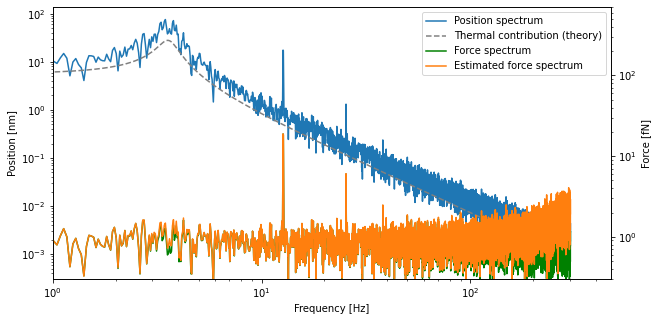

In [7]:
estimated_total_force_spectral_density = q_spectrum / np.abs(susceptibility)
estimated_total_force_spectrum = estimated_total_force_spectral_density

fig, (ax1) = plt.subplots(1, figsize=(10, 5))
ax1.loglog(hertz_to_milli * f, meter_to_nano * q_spectrum, label="Position spectrum")
ax1.loglog(
    hertz_to_milli * f,
    meter_to_nano * theoretical_spectrum_without_force,
    '--',
    color="gray",
    label="Thermal contribution (theory)"
)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Position [nm]")
ax1.set_xlim((1, None)) # Ignore very low frequencies
ax1.plot([], [], color="green", label="Force spectrum") # Fake plot to make single legend.
ax1.plot([], [], color="#ff7f0e", label="Estimated force spectrum") # Fake plot to make single legend.

ax1.legend()
ax2 = ax1.twinx()
ax2.loglog(hertz_to_milli * f, newton_to_femto * force_spectrum, color="green", label="Total force spectrum")
ax2.loglog(hertz_to_milli * f, newton_to_femto * estimated_total_force_spectrum, color="#ff7f0e")
ax2.set_ylabel("Force [fN]")
ax2.set_ylim((0.3, 7 * 10 ** 2))
plt.show()

From the above plot we see that the weak gravitational force generated by the modulation of the source mass produce two observable peaks in the position spectrum of the test mass (blue line). 

Moreover, the by simply scaling the position spectrum by the inverse of the mechanical susceptibility, one can obtain a very good estimate (orange line) of the actual force spectrum (green line). The force spectrum is, as expected, flat with the exception of the clear modulation peaks corresponding to the weak gravitational signal.

## Comparison with the real experiment


For comparison, this is the plot from the true experiment (extracted from [arXiv:2009.09546](https://arxiv.org/abs/2009.09546)):

<div>
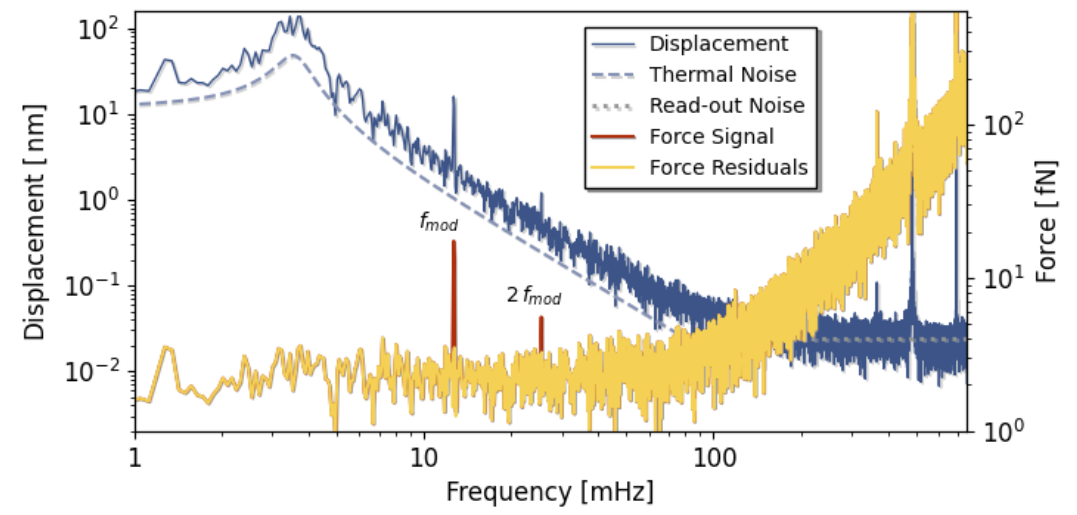
</div>

We managed to (numerically) reproduce the results of the experiment with a notable quantitative agreement! However, we note that in the spectrum of the actual experiment there is a plateau at high frequencies due to detection noise (not considered in this notebook). High-frequency detection noise is anyway irrelevant for the observation of the low-frequency gravitational signal.